# Sentiment Analysis in Python

This notebook is part of a tutorial that can be found on my [youtube channel here](https://www.youtube.com/channel/UCxladMszXan-jfgzyeIMyvw), please check it out!

In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from 🤗
3. Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import snscrape.modules.twitter as sntwitter
import nltk
# from tqdm.notebook  import tqdm
plt.style.use('ggplot')



## Import latest and greatest Elon Musk's Tweets

In [2]:
df = pd.read_csv('./elon_tweets.csv')
df = df.drop('date', axis=1)
df = df.drop('id', axis=1)
df = df.drop('username', axis=1)
print(df.shape)
tweets = df.head(100)
print(tweets.shape)


(18402, 4)
(100, 4)


In [ ]:
# Read in data



## Quick EDA

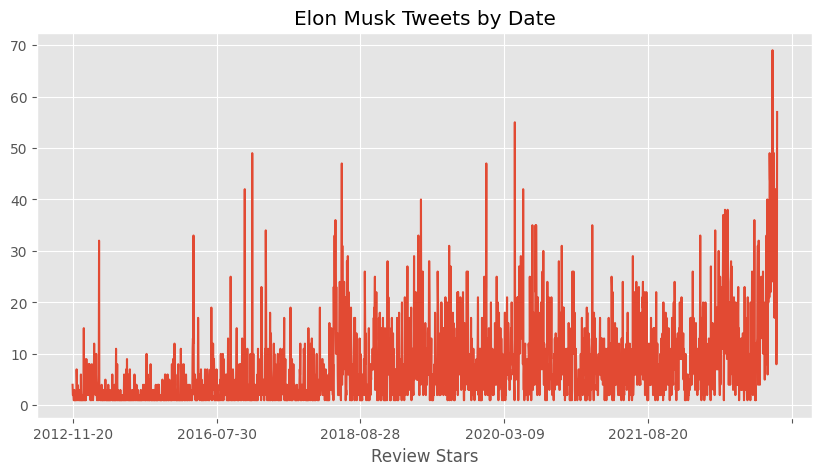

In [3]:
ax = df['ymd'].value_counts().sort_index() \
    .plot(kind='line',
          title="Elon Musk Tweets by Date",
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [4]:
example = tweets['content'][50]
print(example)

twitter is working on a software update that will show your true account status  so you know clearly if you ve been shadowbanned  the reason why and how to appeal


In [5]:
tokens = nltk.word_tokenize(example)
tokens[:10]

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\david/nltk_data'
    - 'c:\\Program Files\\Python\\Python310\\nltk_data'
    - 'c:\\Program Files\\Python\\Python310\\share\\nltk_data'
    - 'c:\\Program Files\\Python\\Python310\\lib\\nltk_data'
    - 'C:\\Users\\david\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


In [27]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('twitter', 'NN'),
 ('is', 'VBZ'),
 ('working', 'VBG'),
 ('on', 'IN'),
 ('a', 'DT'),
 ('software', 'NN'),
 ('update', 'NN'),
 ('that', 'WDT'),
 ('will', 'MD'),
 ('show', 'VB')]

In [28]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  twitter/NN
  is/VBZ
  working/VBG
  on/IN
  a/DT
  software/NN
  update/NN
  that/WDT
  will/MD
  show/VB
  your/PRP$
  true/JJ
  account/NN
  status/NN
  so/IN
  you/PRP
  know/VBP
  clearly/RB
  if/IN
  you/PRP
  ve/VBP
  been/VBN
  shadowbanned/VBN
  the/DT
  reason/NN
  why/WRB
  and/CC
  how/WRB
  to/TO
  appeal/VB)


# Step 1. VADER Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [29]:
!pip3 install twython

In [30]:
from nltk.sentiment import SentimentIntensityAnalyzer
# from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [31]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [32]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [ ]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [ ]:
# Now we have sentiment score and metadata
vaders.head()

## Plot VADER results

In [ ]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
# VADER results on example
print(example)
sia.polarity_scores(example)

In [ ]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

## Compare Scores between models

In [ ]:
results_df.columns

# Step 3. Combine and compare

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [ ]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

In [ ]:
# nevative sentiment 5-Star view

In [ ]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
sent_pipeline('I love sentiment analysis!')

In [ ]:
sent_pipeline('Make sure to like and subscribe!')

In [ ]:
sent_pipeline('booo')

# The End